# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. В наличии исторические данные о поведении клиентов и расторжении договоров с банком. 

Необходимо построить модель с предельно большим значением *F1*-меры.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Upsampling" data-toc-modified-id="Upsampling-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Upsampling</a></span></li><li><span><a href="#Downsampling" data-toc-modified-id="Downsampling-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Downsampling</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

RS = 12345 #Значение параметра random_state

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

Рассмотрим первые пять строчек в исходных данных:

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Согласно документации к данным:
* **RowNumber** — индекс строки в данных;
* **CustomerId** — уникальный идентификатор клиента;
* **Surname** — фамилия;
* **CreditScore** — кредитный рейтинг;
* **Geography** — страна проживания;
* **Gender** — пол;
* **Age** — возраст;
* **Tenure** — сколько лет человек является клиентом банка;
* **Balance** — баланс на счёте;
* **NumOfProducts** — количество продуктов банка, используемых клиентом;
* **HasCrCard** — наличие кредитной карты;
* **IsActiveMember** — активность клиента;
* **EstimatedSalary** — предполагаемая зарплата;
* **Exited** — факт ухода клиента.

Избавимся от столбцов, которые являются бесполезными в данном исследовании, а именно от столбцов `RowNumber`, `CustomerId`, `Surname`.

In [4]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

Изучим пять последних строчек в данных:

In [5]:
df.tail()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


Изучим пять случайных строчек в данных:

In [6]:
df.sample(5, random_state=RS)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7867,640,Spain,Female,46,3.0,0.00,1,1,1,156260.08,0
1402,757,France,Male,29,8.0,130306.49,1,1,0,77469.38,0
8606,807,Spain,Male,42,5.0,0.00,2,1,1,74900.90,0
8885,668,Spain,Male,45,4.0,102486.21,2,1,1,158379.25,0
6494,699,France,Male,28,7.0,0.00,2,1,1,22684.78,0


Изучим основную информацию о данных:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Заметим, что столбец `Tenure` заполнен не полностью. Проверим его на пропуски:

In [8]:
df['Tenure'].isna().sum()

909

Заменим данных пропуски медианным значением:

In [9]:
df['Tenure'].fillna(df.Tenure.median(), inplace=True)

Также обратим внимание на то, что в данных присутствуют столбцы `Geography` и `Gender`, имеющие тип данных *object*. Для преобразования категориальных данных в численные применим технику **OHE**:

In [10]:
df = pd.get_dummies(df, drop_first=True)

Изучим основные описательные статистики:

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,4.997900,2.760010,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00
Geography_Germany,10000.0,0.250900,0.433553,0.00,0.00,0.000,1.0000,1.00


Разделим данные на выборки - обучающую, валидационную и тестовую:

In [12]:
df_train, df_test = train_test_split(df, test_size=0.4, random_state=RS)
df_test, df_valid = train_test_split(df_test, test_size = 0.5, random_state=RS)

Проверим размерность получившихся выборок:

In [13]:
df_train.shape

(6000, 12)

In [14]:
df_test.shape

(2000, 12)

In [15]:
df_valid.shape

(2000, 12)

Выделим целевой признак и остальные признаки для получившихся выборок:

In [16]:
features_train = df_train.drop(['Exited'], axis=1)
target_train = df_train['Exited']

features_valid = df_valid.drop(['Exited'], axis=1)
target_valid = df_valid['Exited']

features_test = df_test.drop(['Exited'], axis=1)
target_test = df_test['Exited']

### Вывод

Предварительно можно утверждать, что имеющихся данных **достаточно** для построения моделей машинного обучения.

В качестве целевой переменной выбран признак **Exited**, характеризующий факт ухода клиента.

Категориальные признаки в таблице были преобразованы в числовые техникой **прямого кодирования**. Данные были разделены на **обучающую**, **валидационную** и **тестовую выборки** в соотношении **3:1:1**

## Исследование задачи

Исследуем баланс классов целевой переменной:

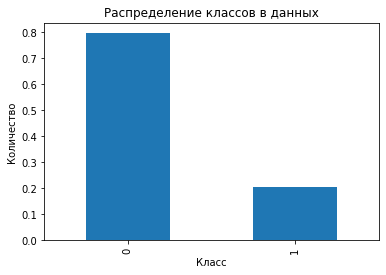

In [17]:
df['Exited'].value_counts(normalize=True).plot(kind='bar')

plt.xlabel('Класс')
plt.ylabel('Количество')
plt.title('Распределение классов в данных')
plt.show()

Исходя из графика можно сказать, что наблюдается сильный **дисбаланс** классов.

Изучим модели без учета дисбаланса. Для исследования выберем модели `RandomForestClassifier` и `LogisticRegression`.

### RandomForestClassifier

Обучим модель, перебирая значения гиперпараметра **depth** при **n_estimators** = **60** для получения максимального значения метрики **f1_score**:

In [18]:
def best_f1(features, target, weight=None):
    f1_values = {}
    for depth in range(1, 16):
        model = RandomForestClassifier(n_estimators=60, max_depth=depth, random_state=RS, class_weight=weight)
        model.fit(features, target)
        predictions_valid = model.predict(features_valid)
        f1_values[depth] = f1_score(target_valid, predictions_valid)
        
    print(f'Максимальное значение f1_score = {max(f1_values.values())} \
достигается при depth = {max(f1_values, key=f1_values.get)}')

In [19]:
best_f1(features_train, target_train)

Максимальное значение f1_score = 0.5413533834586466 достигается при depth = 14


Таким образом, максимальное значение метрики **f1_score** равное **0.54** достигается при значении **depth** = **14**.

In [20]:
model = RandomForestClassifier(n_estimators=60, max_depth=14, random_state=RS)
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

Построим график **ROC** кривой и вычислим площадь под ней при помощи функции:

In [21]:
def roc(model, features, target):
    probabilities = model.predict_proba(features)
    probabilities_one = probabilities[:, 1]
    fpr, tpr, thresholds = roc_curve(target, probabilities_one)
    
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show()
    
    print(f'Площадь под графиком: {roc_auc_score(target, probabilities_one).round(2)}')

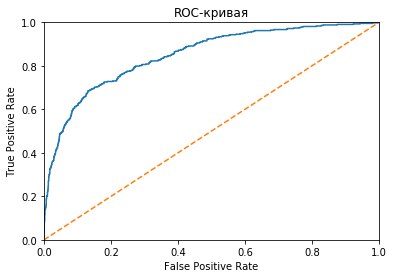

Площадь под графиком: 0.85


In [22]:
roc(model, features_valid, target_valid)

### LogisticRegression

Перед обучением модели логистической регрессии нормируем значения признаков:

In [23]:
scaler = StandardScaler()
scaler.fit(features_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)

Обучим модель:

In [25]:
model = LogisticRegression(random_state=RS, solver='liblinear')
model.fit(features_train_scaled, target_train)
predictions_valid = model.predict(features_valid_scaled)

Значение метрики **f1_score**:

In [26]:
f1_score(target_valid, predictions_valid)

0.27478260869565213

Построим график **ROC** кривой и вычислим площадь под ней:

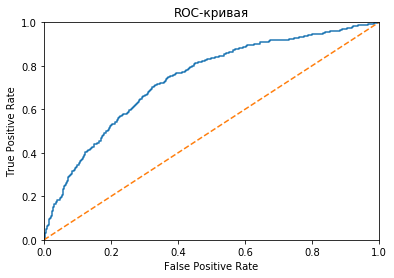

Площадь под графиком: 0.74


In [27]:
roc(model, features_valid_scaled, target_valid)

### Вывод

Наблюдается сильный **дисбаланс** классов в исходных данных.

Для моделей **без учета** дисбаланса классов получили следующие значения метрики **f1_score**:
* `Случайный лес` - **0.54**
* `Логистическая регрессия` - **0.27**

Очевидно, что значения метрики **AUC-ROC** также будут **больше** у модели **случайного леса**: **0.85** против **0.74** у **логистической регрессии**.

## Борьба с дисбалансом

Изучим поведение метрики при при использовании аргумента `class_weight='balanced'`. Также найдем оптимальное значение гипер параметра `depth` для модели `Случайного леса`.

Для модели `RandomForestClassifier`:

In [28]:
best_f1(features_train, target_train, weight='balanced')

Максимальное значение f1_score = 0.6185792349726776 достигается при depth = 8


Для модели `LogisticRegression`:

In [29]:
model = LogisticRegression(class_weight='balanced')
model.fit(features_train_scaled, target_train)
predictions_valid = model.predict(features_valid_scaled)

Значение метрики **f1_score**:

In [30]:
f1_score(target_valid, predictions_valid)

0.4775086505190312

Заметим, что значение метрики **f1_score** для `Логистической регрессии` значительно **выросло**. Однако использование модели `Случайного леса` все еще дает **наилучший** результат.

Рассмотрим применение методов изменения размеров выборок для данной модели с целью увеличения метрики **f1_score** (Upsampling и Downsampling)

### Upsampling

Создадим функцию, возвращающую **увеличенные** выборки:

In [31]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=RS)
    
    return features_upsampled, target_upsampled

In [32]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

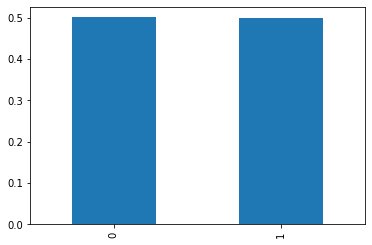

In [33]:
target_upsampled.value_counts(normalize=True).plot(kind='bar')

Найдем оптимальное значение **depth**:

In [34]:
best_f1(features_upsampled, target_upsampled, weight='balanced')

Максимальное значение f1_score = 0.6143001007049346 достигается при depth = 8


Обучим модель на полученных данных:

In [35]:
model = RandomForestClassifier(n_estimators=60, max_depth=8, random_state=RS, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)

Построим график **ROC** кривой и вычислим площадь под ней:

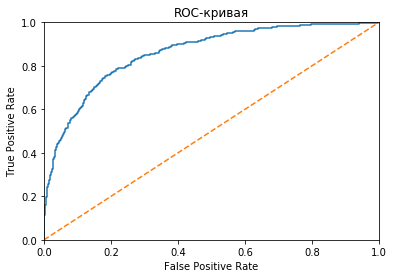

Площадь под графиком: 0.86


In [36]:
roc(model, features_valid, target_valid)

### Downsampling

Создадим функцию, возвращающую **уменьшенные** выборки:

In [37]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [38]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)

Найдем оптимальное значение **depth**:

In [39]:
best_f1(features_downsampled, target_downsampled, weight='balanced')

Максимальное значение f1_score = 0.6136865342163356 достигается при depth = 11


Обучим модель на полученных данных:

In [40]:
model = RandomForestClassifier(n_estimators=60, max_depth=11, random_state=RS, class_weight='balanced')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

Построим график **ROC** кривой и вычислим площадь под ней:

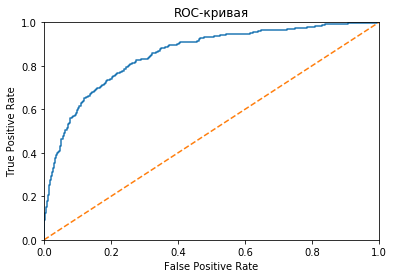

Площадь под графиком: 0.85


In [41]:
roc(model, features_valid, target_valid)

### Вывод

Для увеличения метрики **f1_score** были использованы следующие методы:
* Взвешивание классов
* Увеличение выборки
* Уменьшение выборки

Анализ результатов показал, что оба метода, используемых для повышения исследуемой метрики были практически одинаково **эффективны**: значение **f1_score** = **0.61**, что **на** **0.07** **превышает** предыдущий результат.

Также удалось повысить метрику **ROC-AUC** на **0.1**

## Тестирование модели

Проведем финальное исследование на **тестовой** выборке:

In [42]:
model = RandomForestClassifier(n_estimators=60, max_depth=8, random_state=RS, class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)

Значение метрики **f1_score**:

In [43]:
f1_score(target_test, predicted_test)

0.6171310629514963

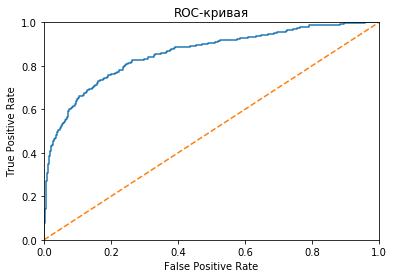

Площадь под графиком: 0.86


In [44]:
roc(model, features_test, target_test)

### Вывод

Полученное значение **f1_score** **подтвердилось** на тестовых данных.

## Общий вывод

В данном исследовании были рассмотрены модели `Случайного леса` и `Логистической регрессии`.

Первоначально проведен анализ метрики **f1_score** и **AUC_ROC** без учета дисбаланса классов. В качестве основной модели была выбрана модель **RandomForestClassifier**, так как ее использование дало более высокие значения исследуемых метрик:
* `f1_score = 0.54`
* `ROC-AUC = 0.85`

Применение **взвешивания классов** и **уменьшение выборки** по итогу позволило достичь **наилучшее** значение исследуемой метрики: `f1_score = 0.61`

Анализ на тестовых данных также **подтвердил** полученное значение.